# LeNet-5 from scratch
Here's the hardware used to train the model. Please note that the training might be slow due to the fact that this code is implemented w/o GPU acceleration.



In [ ]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        256 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

# Import dependencies

In [ ]:
import numpy as np
import tqdm
import struct
import random
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Data Preparation
We use a MNIST dataset distribution from keras here.

In [ ]:
(train_data, train_label), (test_data, test_label) = mnist.load_data()
print ("MNIST data loaded")
print ("Training data shape:",train_data.shape)
print ("Test data shape:",test_data.shape)

11490434/11490434 [==============================] - 0s 0us/step
MNIST data loaded
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


Normalize the dataset with the mean value and standard deviation of the training set.

In [ ]:
mean = np.mean(train_data)
std = np.std(train_data)

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# Code up net layers

Here's the implementation of network layers.

Please note that all tensors are of (N, C, H, W) manner.

In [ ]:
class Conv():
    def __init__(self, in_ch, out_ch, kernel_size, padding=0, bias=True):
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.weight = {'val': np.random.normal(0.0,np.sqrt(2/in_ch),(out_ch,in_ch,kernel_size,kernel_size)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(out_ch), 'grad': 0}
        self.cache = None
        self.pad = padding

    def _forward(self, X):
        X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, in_ch, H, W) = X.shape
        H_ = H - self.kernel_size + 1
        W_ = W - self.kernel_size + 1
        Y = np.zeros((N, self.out_ch, H_, W_))

        for n in range(N):
            for c in range(self.out_ch):
                for h in range(H_):
                    for w in range(W_):
                        Y[n, c, h, w] = np.sum(X[n, :, h:h+self.kernel_size, w:w+self.kernel_size] * self.weight['val'][c, :, :, :]) + self.b['val'][c]

        self.cache = X
        return Y

    def _backward(self, dout):
        X = self.cache
        (N, in_ch, H, W) = X.shape
        H_ = H - self.kernel_size + 1
        W_ = W - self.kernel_size + 1
        W_rot = np.rot90(np.rot90(self.weight['val']))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.weight['val'].shape)
        db = np.zeros(self.b['val'].shape)

        for co in range(self.out_ch):
            for ci in range(self.in_ch):
                for h in range(self.kernel_size):
                    for w in range(self.kernel_size):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])

        for co in range(self.out_ch):
            db[co] = np.sum(dout[:,co,:,:])
        dout_pad = np.pad(dout, ((0,0),(0,0),(self.kernel_size,self.kernel_size),(self.kernel_size,self.kernel_size)), 'constant')


        for n in range(N):
            for ci in range(self.in_ch):
                for h in range(H):
                    for w in range(W):
                        dX[n, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[n, :, h:h+self.kernel_size,w:w+self.kernel_size])

        self.weight['grad'] = dW
        self.b['grad'] = db

        return dX

In [ ]:
class MaxPool():
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        self.cache = None

    def _forward(self, X):
        (N,in_ch,H,W) = X.shape
        kernel_size = self.kernel_size
        W_ = int(float(W)/kernel_size)
        H_ = int(float(H)/kernel_size)
        Y = np.zeros((N,in_ch,W_,H_))
        M = np.zeros(X.shape) 
        for n in range(N):
            for cin in range(in_ch):
                for w_ in range(W_):
                    for h_ in range(H_):
                        Y[n,cin,w_,h_] = np.max(X[n,cin,kernel_size*w_:kernel_size*(w_+1),kernel_size*h_:kernel_size*(h_+1)])
                        i,j = np.unravel_index(X[n,cin,kernel_size*w_:kernel_size*(w_+1),kernel_size*h_:kernel_size*(h_+1)].argmax(), (kernel_size,kernel_size))
                        M[n,cin,kernel_size*w_+i,kernel_size*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,in_ch,H,W) = M.shape
        dout = np.array(dout)
        dX = np.zeros(M.shape)
        for n in range(N):
            for c in range(in_ch):
                dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)
        return dX*M

In [ ]:
class ReLU():
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        out = np.maximum(0, X)
        self.cache = X
        return out

    def _backward(self, dout):
        X = self.cache
        dX = np.array(dout, copy=True)
        dX[X <= 0] = 0
        return dX

In [ ]:
class FC():
    def __init__(self, D_in, D_out):
        self.cache = None
        self.weight = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        out = np.dot(X, self.weight['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        X = self.cache
        dX = np.dot(dout, self.weight['val'].T).reshape(X.shape)
        self.weight['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        return dX

##Optimizer and loss function
This is an implementation of stochastic gradient descent optimizer.

In [ ]:
class SGD():
    def __init__(self, params, lr=0.001, weight_decay=0):
        self.parameters = params
        self.lr = lr
        self.weight_decay = weight_decay

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.weight_decay*param['val'])


Here is an implementation of Cross entropy loss.

In [ ]:
class Softmax():
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        maxes = np.amax(X, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(X - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (X, Y, Z)
        return Z

    def _backward(self, dout):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(dout,dZ)
        dX = np.dot(dX,dY)
        return dX

In [ ]:
def NLLLoss(Y_pred, Y_true):
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N

In [ ]:
class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax._forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

Helper functions.

In [ ]:
def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

In [ ]:
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Here's an easy implementation of dataset:

In [ ]:
class dataset():
  def __init__(self, data, label, batch_size) -> None:
    self.data = np.expand_dims(data, axis=1)
    self.label = label
    self.batch_size = batch_size

  def __getitem__(self, index):
    if index >= len(self):
      raise IndexError
    lower = index * self.batch_size
    higher = min(lower + self.batch_size, self.data.shape[0])
    x = np.zeros((self.batch_size, 1, self.data.shape[1], self.data.shape[2]))
    y = np.array(self.label[lower:higher])
    x = self.data[lower:higher,:]
    y = MakeOneHot(y, 10)
    return x, y

  def __len__(self):
    return np.ceil(self.data.shape[0]/self.batch_size).astype(int)

# Code up LeNet-5

In [ ]:
class LeNet5():
    # Credit to Lecun Yann
    def __init__(self):
        self.conv1 = Conv(1, 6, 5)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool(2)
        self.conv2 = Conv(6, 16, 5)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool(2)
        self.FC1 = FC(16*4*4, 120)
        self.ReLU3 = ReLU()
        self.FC2 = FC(120, 84)
        self.ReLU4 = ReLU()
        self.FC3 = FC(84, 10)
        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.ReLU1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.ReLU2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.ReLU3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.ReLU4._forward(h4)
        h5 = self.FC3._forward(a5)
        return h5

    def backward(self, dout):
        dout = self.FC3._backward(dout)
        dout = self.ReLU4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.weight, self.conv1.b, self.conv2.weight, self.conv2.b, self.FC1.weight, self.FC1.b, self.FC2.weight, self.FC2.b, self.FC3.weight, self.FC3.b]

    def set_params(self, params):
        [self.conv1.weight, self.conv1.b, self.conv2.weight, self.conv2.b, self.FC1.weight, self.FC1.b, self.FC2.weight, self.FC2.b, self.FC3.weight, self.FC3.b] = params


# Model training
Hyperparams go here:

In [ ]:
BATCH_SIZE = 32
LR = 0.0001
WEIGHT_DECAY = 0.0003
EPOCHES = 2

In [ ]:
train_loader = dataset(train_data, train_label, BATCH_SIZE)
test_loader = dataset(test_data, test_label, BATCH_SIZE)

In [ ]:
model = LeNet5()
losses = AverageMeter()
loss_cache = []
optim = SGD(model.get_params(), lr=LR, weight_decay=WEIGHT_DECAY) 
criterion = CrossEntropyLoss()

for epoch in range(EPOCHES):
  print(f"Epoch {epoch}:\n")
  pbar = tqdm.tqdm(range(len(train_loader))) 
  for i, (x, y) in enumerate(train_loader):
    logit = model.forward(x)
    loss, dout = criterion.get(logit, y)
    model.backward(dout)
    optim.step()

    losses.update(loss)
    pbar.update()
    pbar.set_description("loss:{}".format(losses.avg))
    if i % 2 == 0:
      loss_cache.append(loss)
  pbar.close()


Epoch 0:



loss:0.9638563985795905: 100%|██████████| 1875/1875 [1:20:44<00:00,  2.58s/it]


Epoch 1:



loss:0.6208537644248767: 100%|██████████| 1875/1875 [1:19:56<00:00,  2.56s/it]


# Test result

In [ ]:
confusion_matrix = np.zeros((10,10),int)
for i,(x, y) in enumerate(test_loader):
  logit = model.forward(x)
  pred = np.argmax(logit, axis=1)
  gt = np.argmax(y, axis=1)
  for j in range(len(pred)):
    confusion_matrix[gt[j]][pred[j]] += 1

acc = confusion_matrix.diagonal().sum() / confusion_matrix.sum()
print("Test accuracy is: {}".format(acc))
print("Confusion matrix:\n",confusion_matrix)

Test accuracy is: 0.9341
Confusion matrix:
 [[ 962    1    0    1    0    5    8    1    1    1]
 [   0 1121    2    4    0    3    1    0    3    1]
 [  17   11  918    6   21    1   10   14   29    5]
 [   3    3    9  945    1   14    0    4    9   22]
 [   1    4    3    0  920    0   10    0    2   42]
 [   8    2    2   23    1  825    7    2    9   13]
 [  12    4    3    0   12   19  904    0    4    0]
 [   3   20   36    7    8    1    0  912    2   39]
 [   3    2    5   18    5   16    3    3  877   42]
 [  10    4    2   10   10    5    0    7    4  957]]


Plot the convergence graph using matplotlib. 

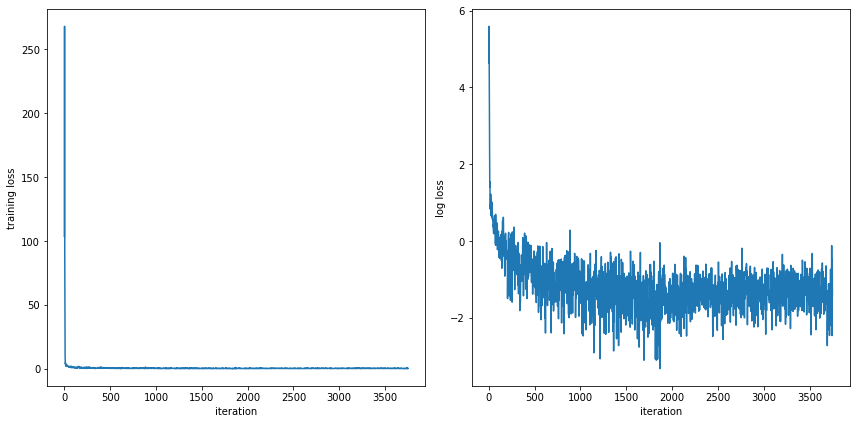

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(range(0, len(loss_cache * 2), 2), loss_cache)
plt.xlabel('iteration')
plt.ylabel('training loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, len(loss_cache * 2), 2), np.log(loss_cache))
plt.xlabel('iteration')
plt.ylabel('log loss')

plt.tight_layout()
plt.show()

[Text(57.5, 0.5, 'Actual'), Text(0.5, 57.5, 'Predicted')]

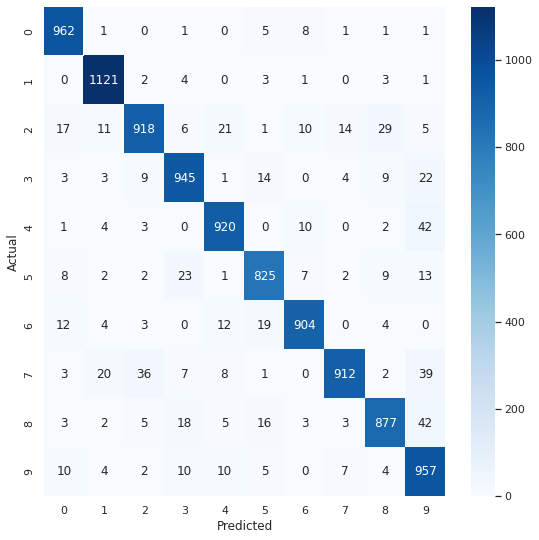

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(9,9)})
s = sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
s.set(xlabel='Predicted', ylabel='Actual')